# Convolutional Neural Network Visualization

<br> <p style='text-align:justify'>The purpose of this notebook is to demonstrate how to visualize two kinds of interesting information in a CNN model: weights and activations. By activation I mean the output of a layer. By looking at the weights and activation one can have a better grasp of what kind of features and representations the network is learning and producing. </p>

<p style='text-align:justify'>To not get involved with the training process of a CNN model, I decided to choose a pre-trained CNN so that we can directly visualize things. Here, VGG16 is chosen to serve this purpose. The main library for this notebook is Keras.</p>

First, let's import some required libaries.

In [191]:
import numpy as np
import keras
from keras.applications import VGG16
import matplotlib.pyplot as plt
from matplotlib import gridspec
from keras import backend as K
from sklearn.datasets import load_digits
import cv2

The next step is to load the pre-trained VGG16 model. 

In [192]:
model = VGG16(weights='imagenet')

One of the first things that we can do now is to take a look at the model summary. Doing so is a good way of getting to know what the model looks like and what kind of components it is made up of.

In [193]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

<p style='text-align:justify'>It is called VGG16 since it contains 16 layers. It is worth to mention that the input is not considered as a layer. Excluding input,if we simply count the number of rows in the model summary, it is larger than 16. The reason is that MaxPooling2D is not considered as a layer itself. A Maxpooling2D operation follows a conv layer and then together they count as a layer. Also a conv layer which is not followed by pooling is also considered as a layer. Flattern operation is also is not considered as a layer. In other words, each row that has no parameters associated to,which is indicated in the last column, is not considered as layer itself. This seems quite logical since there is no parameter to train for those operations.</p>

Let's take a look at the model diagram and match it up with the model summary.

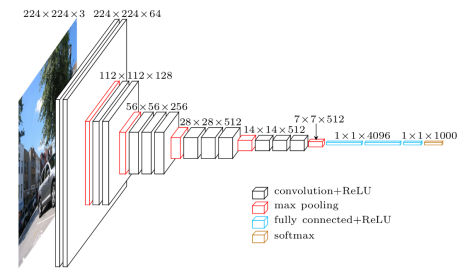

In [194]:
from IPython.display import Image
Image(filename='./Pics/vgg16.png')

# Visualizing model weights

To get access to the model's weights and biases we can use the following command.

In [195]:
weights, biasses = model.get_layer('block1_conv1').get_weights()

Note that get_layer function takes layers name as its argument. Basically, we can pass a layer name to this function to get the parameters of that layer.

Let's look at the shape of weights and biases of the first convulation layer, i.e., block1_conv1.

In [196]:
print('Weight shape is:'+str(weights.shape))
print('Bias shape is:'+str(biasses.shape))

Weight shape is:(3, 3, 3, 64)
Bias shape is:(64,)


<p style='text-align:justify'>The first three arguments in weight shape are width,height, and depth of the filters respectively. Since the filter sizes in VGG16 are all 3 by 3, the first two arguments must be (3,3). The third argument which is depth must match with input of that layer. Since input to this layer is the input image itself, it contains 3 channels. The last argument is the number of filters which in this layer is chosen to be 64. As for the bias size, since there are 64 filters and each filter has one coefficient as bias the size has to be (64,).</p>

Let's do the same for the next conv layer, i.e., block1_conv2.

In [197]:
weights, biasses = model.get_layer('block1_conv2').get_weights()
print('Weight shape is:'+str(weights.shape))
print('Bias shape is:'+str(biasses.shape))

Weight shape is:(3, 3, 64, 64)
Bias shape is:(64,)


Notice that the only difference compare to the previous layer is that the third argument is 64. And it must be the case since the input to this layer is the output of the previous conv layer which has the depth of 64.

It is time to define a function that can display the weight of a given conv layer at a given channel in a grid. The function takes the followings as its arguments:

- layername: name of the layer
- channelNum: Channel index in a layer
- gridSize

In [198]:
def gridWeights(layername,channelNum, gridSize):
    
    weights, biasses = model.get_layer(layername).get_weights()
    fig, ax = plt.subplots(gridSize[0],gridSize[1],figsize=(16,16))
    cnt = 0
    for i in range(gridSize[0]):
        for j in range(gridSize[1]):

            im = weights[:,:,channelNum,cnt]
            ax[i,j].imshow(im,cmap='gray')
            cnt+=1

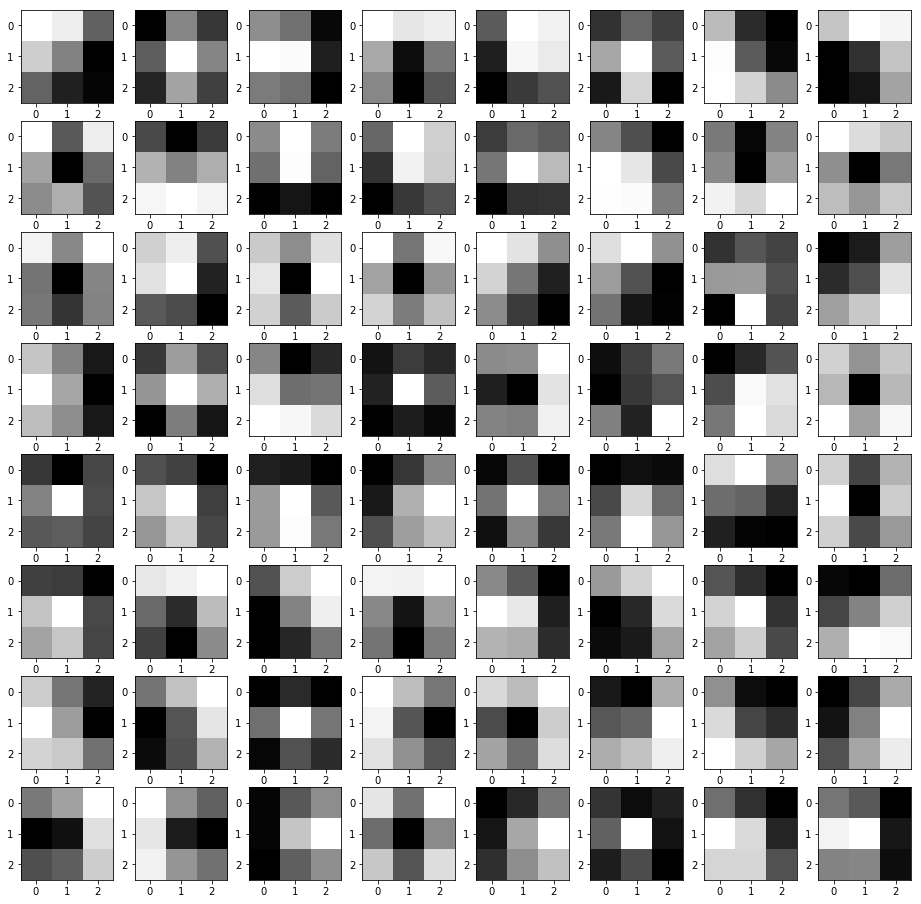

In [199]:
gridWeights('block1_conv1',0,(8,8))

<p style='text-align:justify'>So, calling the gridWeight function like above, the grid shows the learnt weights of the first conv layer at channel 0 which is the red channel of the input image. What it means is that these filters are convolved with the the red channel of the image to detect features in that channel.</p>

<p style='text-align:justify'> One can think of what kind of features each of these filters can extract. For example, if we consider the first one, top left, it is kind of specialized for detecting 45 degree edges. </p>

# Visualizing filters with their convolution effect on input

<p style='text-align:justify'>Another meaningful kind of visualization is to depict effect of each fiter of an input. An appropriate way of doing so is to select a specific filter and illustrate the filter and its effect on the input together. In order to to this, we need to define a function that takes a layername and an input image and returns the activations of that layer as output, and then from the activations of that layer we can select an specific activation tied to a specific filter in that layer. </p>

The following function(get_activation) takes the followings as its input.

- model: for example the VGG16 model
- layer: this is the layer index
- X_batch: input we are interested in

In [200]:
def get_activation(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], \
                                 [model.layers[layer].output,])
    activations = get_activations([X_batch,0])
    return activations

The important part of the above function is K.function part. Three arguments which are passed to this function are as follows.

- model.layer[0].input:  This is the input which we are interested in getting its activation in a layer. And since we are looking at layers[0] it is equivalent to the input image.
- K.learning_phase():   The learning phase which for test is zero and for train is one. Since we are not training, this value is zero which shows that we are interested just in testing.
- model.layers[layername].output:   It is the output(activations) of a specific layer that we are interested in.

Now, let's define another function that wraps around the above function. It takes followings as its arguments.

- model: for example the VGG16 model
- layername: name of a layer
- layers : a dictionary with layernames as keys and index of corresponding layers as values
- img: the image that we are interested in getting its activation in layer(layername)
- nrow,ncol: these two arguments are used for the purpose of reshaping

In [201]:
def get_activation_from_layer(model,layername,layers,img,nrow,ncol):
    
  if 'input' not in layername:
      acti = get_activation(model, layers[layername], img.reshape(1,nrow, ncol,3))[0]
      activation = np.squeeze(acti,axis=0)
  else:
    activation = img

  
  return activation

The img is reshaped so that if the input is for example a grayscale with one channel will end up with 3 channels to be matched with the input of the VGG16 model.

The following code creates a dictionary with layernames as keys and index of corresponding layers as values.

In [202]:
layers = dict()
index = None
for idx, layer in enumerate(model.layers):
  layers[layer.name] = idx

It is time to get and image and feed it through the network using the defined function to see the actications of it in layers.

In [203]:
filename = './Pics/lena_color_512.tif'

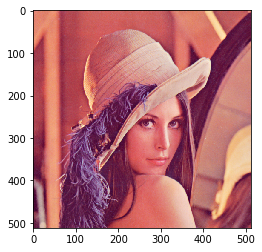

In [204]:
img1 = cv2.imread(filename,3)
b,g,r = cv2.split(img1)           
img1 = cv2.merge([r,g,b])
nrow,ncol,nc = img1.shape
plt.imshow(img1)

In [205]:
def plotActivation(model,layername,previous_layername,filter_num):

    fig,axes = plt.subplots(4,1,figsize=(16,16))
    nrows = 3
    ncols = 3  
    G = gridspec.GridSpec(nrows, ncols)

    weights, biasses = model.get_layer(layername).get_weights()
    
    previous_activation = get_activation_from_layer(model,previous_layername,layers, img1,nrow,ncol)
    activation = get_activation_from_layer(model,layername,layers, img1,nrow,ncol)
    activation = activation[:,:,filter_num]
    
    prev_act = previous_activation[:,:,:3]


    ax0 = plt.subplot(G[0,0])
    ax0.imshow(prev_act[:,:,0],cmap='gray')
    ax0.set_title('First channel of the input')
    ax1 = plt.subplot(G[0,1])
    ax1.imshow(prev_act[:,:,1],cmap='gray')
    ax1.set_title('Second channel of the input')
    ax2 = plt.subplot(G[0,2])
    ax2.imshow(prev_act[:,:,2],cmap='gray')
    ax2.set_title('Third channel of the input')



    ax3 = plt.subplot(G[1,0])
    ax3.imshow(weights[:,:,0,filter_num],cmap='gray')
    ax3.set_title('First channel of filter')
    ax4 = plt.subplot(G[1,1])
    ax4.imshow(weights[:,:,1,filter_num],cmap='gray')
    ax4.set_title('Second channel of filter')
    ax5 = plt.subplot(G[1,2])
    ax5.imshow(weights[:,:,2,filter_num],cmap='gray')
    ax5.set_title('Third channel of filter')

    ax6 = plt.subplot(G[2,0:])
    ax6.imshow(activation,cmap='gray')
    ax6.set_title('Aggregated result of there three channels of the filter on the image')

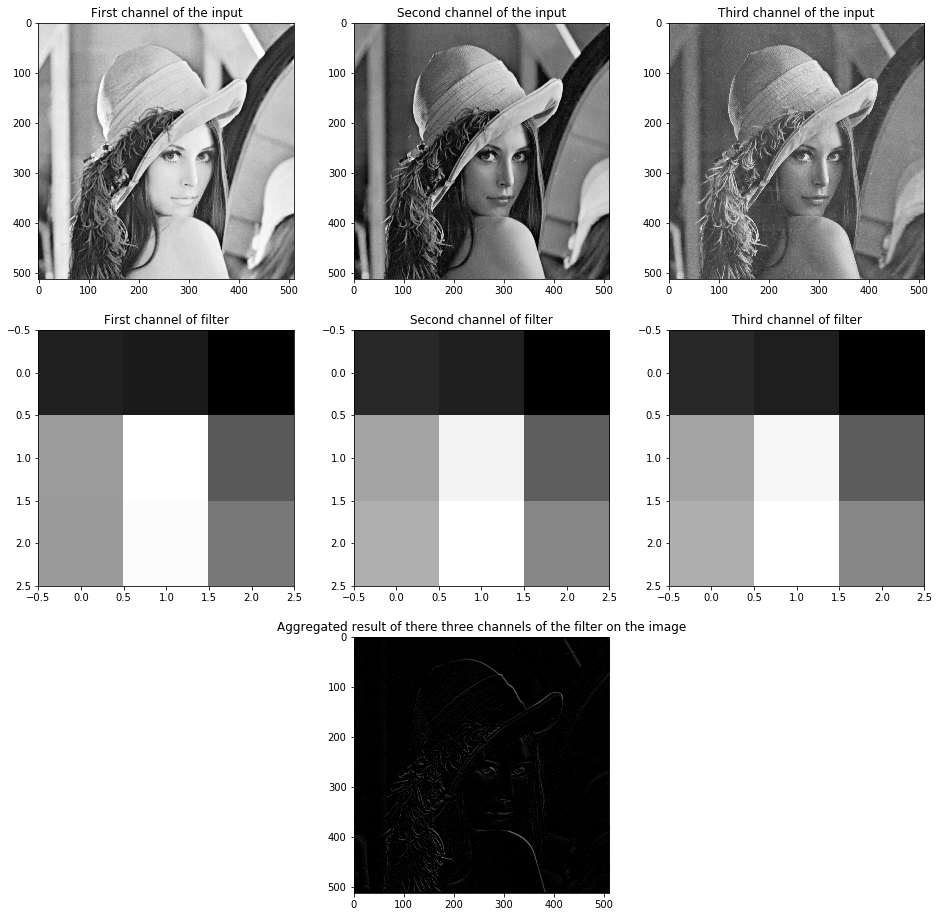

In [206]:
plotActivation(model,'block1_conv1','input_3',34)

<p style='text-align:justify'>For the sake of illustration block1_conv1 is chosen as the layer because the filters in this layers have depth 3 and hence easier to show. If you want to do the same for let's say the block1_conv2, since it has filters with depth 64 and if you want to see all channels of a filter at the same time you need to depicts all 64 channels. However, it is better to select subset of channels to show.</p>

<p style='text-align:justify'>In the example above filter number 34 is chosen. You can change it to see the effect of different filters. And as mentioned above you can change layer name also to see the the effect of filters in other layers as well.</p>

<p style='text-align:justify'> Also, note that in the example, all 3 channels of the filter 34 are very similar together. If you display other filters in the first convolution layer, the interesting fact is that in most of them the three channels are very similar. And it kind of make sense since R,G, and B channels of the input image are very similar as well. Now let's do the same experiment for another conv layer.

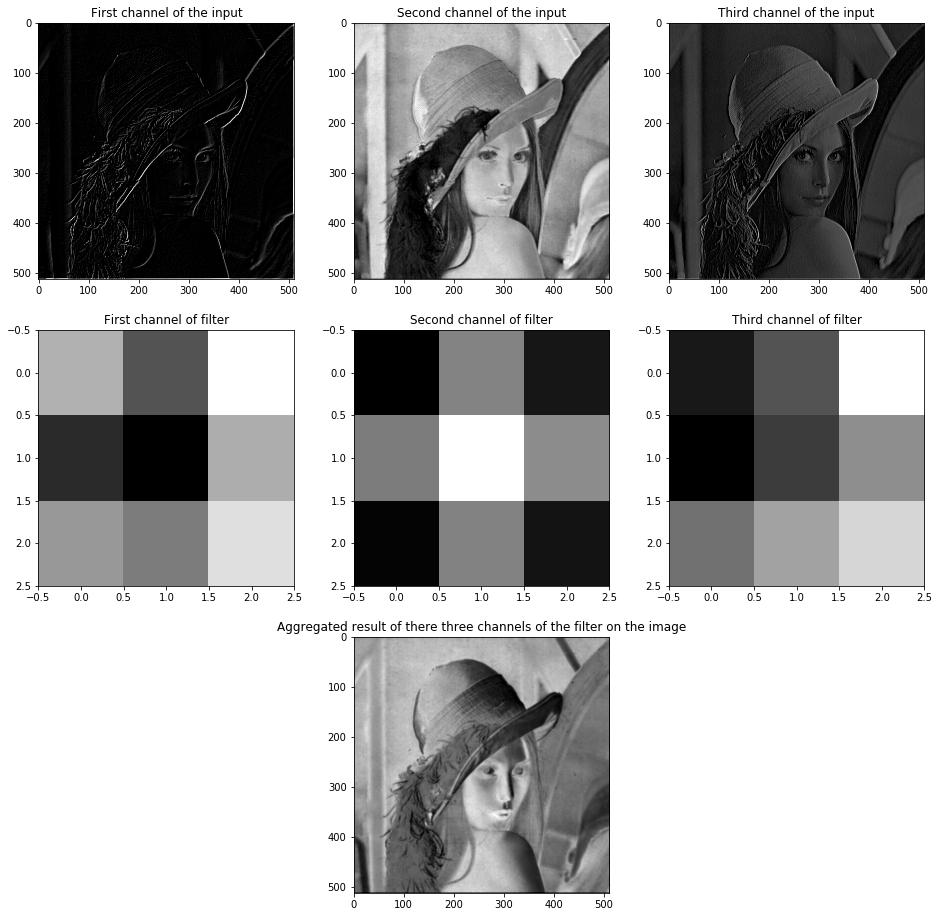

In [207]:
plotActivation(model,'block1_conv2','block1_conv1',2)

Now, you can see that for the filter in the the second layer convolutional the channels look very different. Notice that in this layer every filter has 64 channels. Only the first three channels of that filter is shown,

# Visualizing activations of different layers in a grid

<p style='text-align=justify'>Another way that we can visualize is that we can go through the network from beginning to end and depicts representation of the image in different layers to see how the representation becomes more and more abstract as we go through the network towards the last layer. Basically, we are going to do the same thing as we did already. The only difference is that we are going to see a collection of activations of a layer together.</p>

In [208]:
def plotGridActivation(model,layers,layername):

    fig, ax = plt.subplots(8,8,figsize=(16,16))

    weights, biasses = model.get_layer(layername).get_weights()
    activation = get_activation_from_layer(model,layername,layers, img1,nrow,ncol)
    cnt = 0
    for i in range(8):
        for j in range(8):

            im = activation[:,:,cnt]
            ax[i,j].imshow(im,cmap='gray')
            cnt+=1

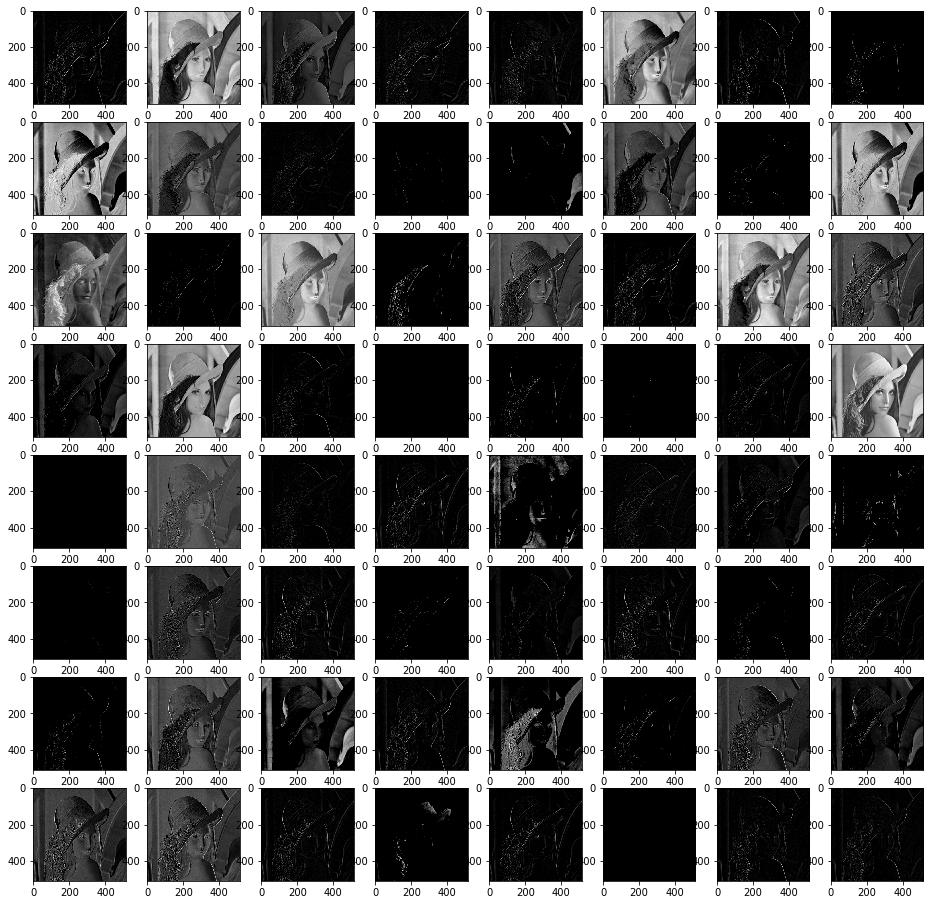

In [209]:
plotGridActivation(model,layers,'block1_conv1')

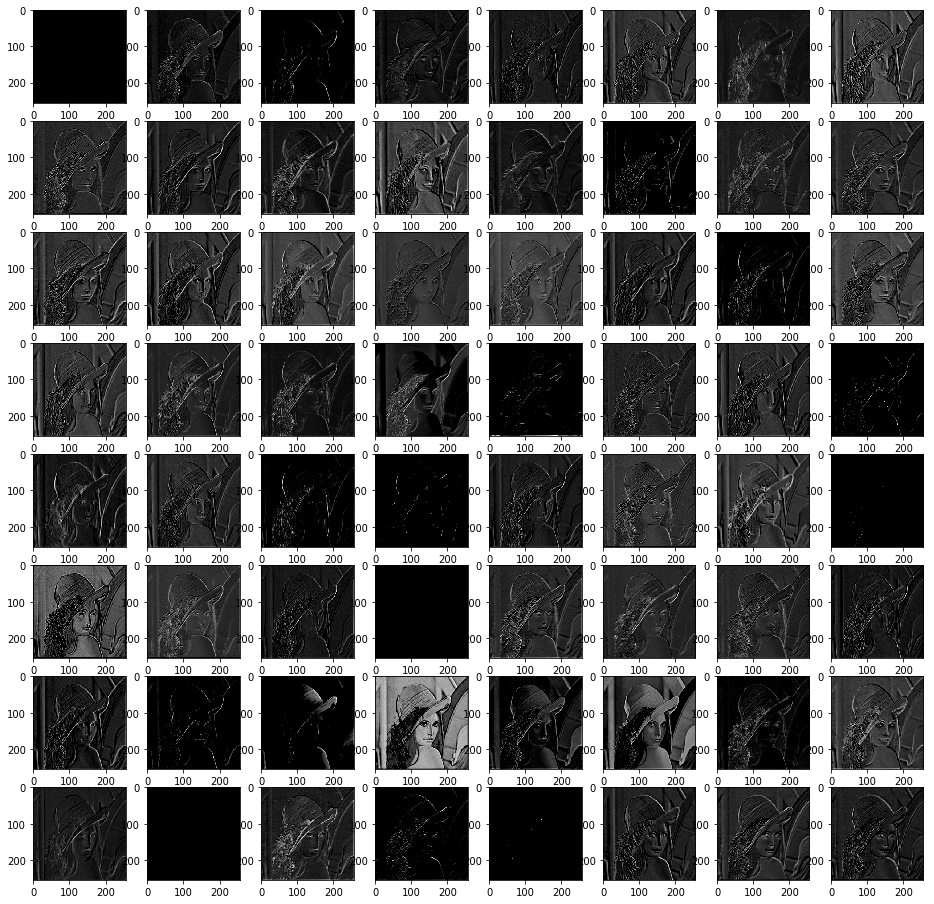

In [210]:
plotGridActivation(model,layers,'block2_conv1')

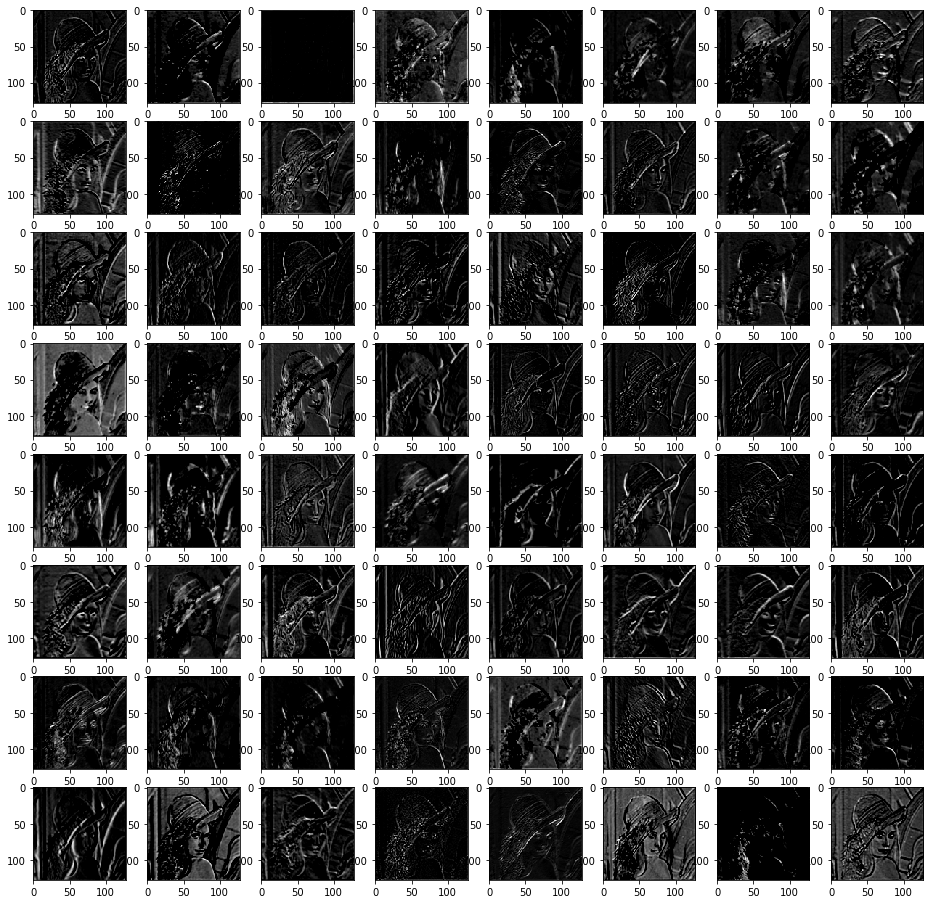

In [211]:
plotGridActivation(model,layers,'block3_conv1')

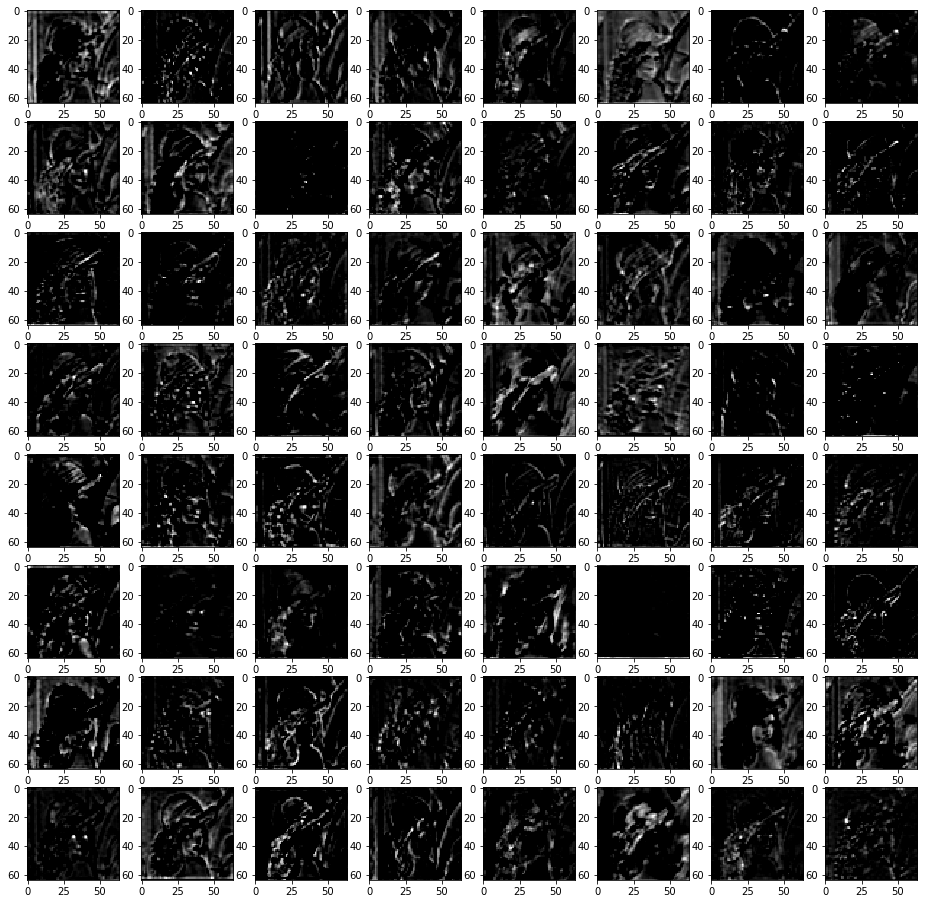

In [212]:
plotGridActivation(model,layers,'block4_conv1')

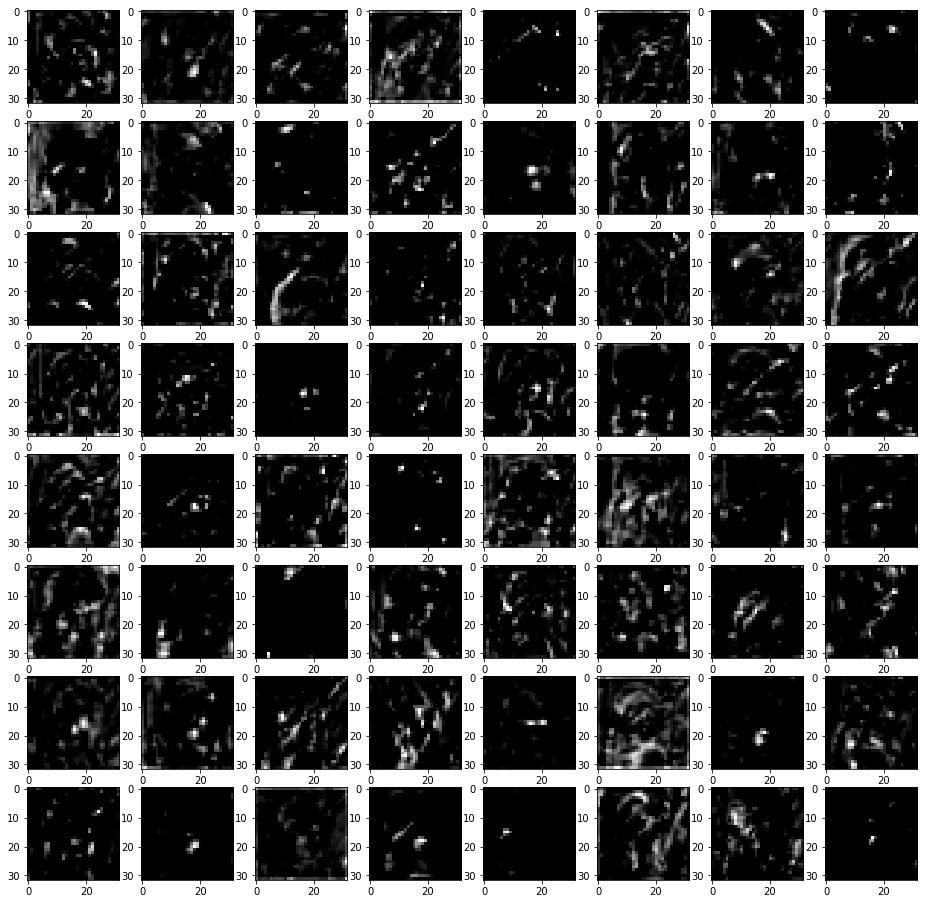

In [213]:
plotGridActivation(model,layers,'block5_conv1')

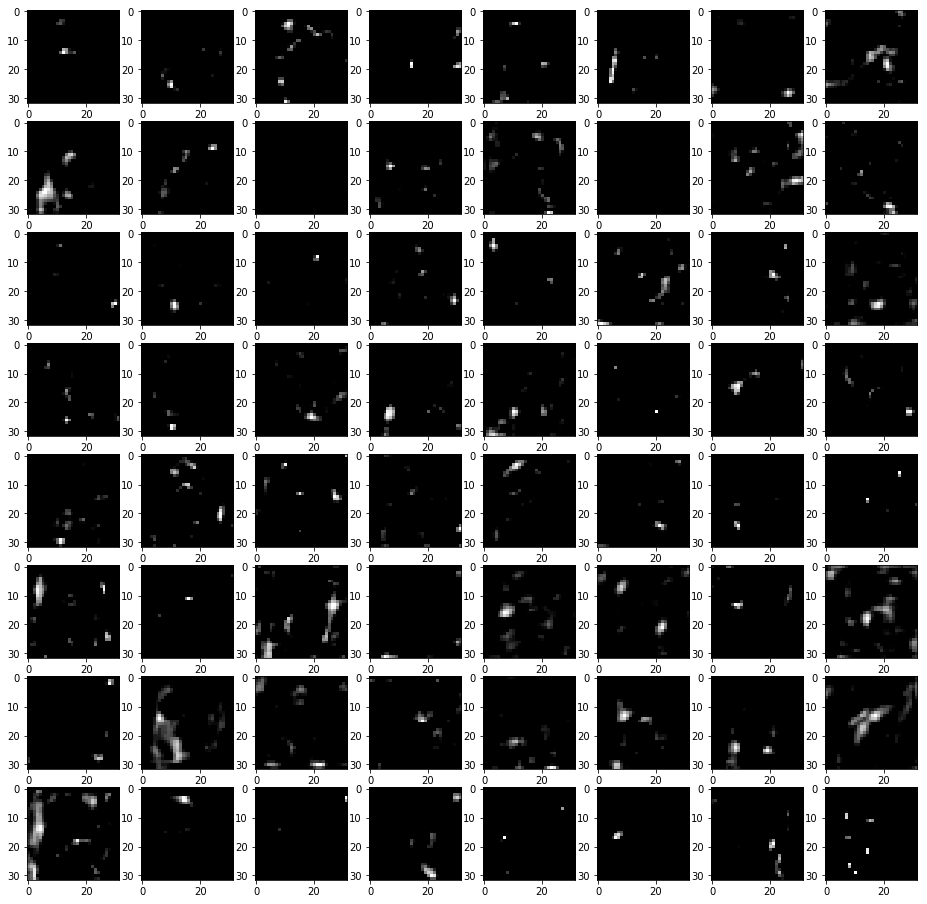

In [214]:
plotGridActivation(model,layers,'block5_conv3')

<p style='text-align:justify'>What we are seeing above is the activations for some conv layers from beginning to the end of the convolutional part of the network.As we can see, the more we go through the network, the more abstract the representations become. Essentially, what the network does is to transform the images to a representation that can be classified through a linear classier in the last layer of the network(last dense layer).</p>